In [ ]:
import scipy.stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
import yfinance as yf
import pandas as pd
from datetime import date
import apimoex
import requests
from scipy.stats import norm

In [ ]:
def get_moex_index(ticker, start = '2022-01-01', end = '2023-01-01'):
    with requests.Session() as session:
        data = apimoex.get_market_history(session = session, security = ticker, start = start,  end = today, market = 'index', engine = "stock")
        df = pd.DataFrame(data)
        df['TRADEDATE'] = pd.to_datetime(df['TRADEDATE']).dt.date
        df.drop('BOARDID', axis=1, inplace=True)
        df.drop('VOLUME', axis=1, inplace=True)
        df.rename({'TRADEDATE':'date', 'VALUE':'volume', 'CLOSE':'close'}, axis='columns', inplace = True)
        df.set_index('date', inplace=True)
    return df

def get_moex_stock(ticker, start = '2012-01-01', end = '2023-01-01'):
    with requests.Session() as session:
        data = apimoex.get_market_candles(session = session, security = ticker, start = start,  end = end)
        df = pd.DataFrame(data)
        df['begin'] = pd.to_datetime(df['begin']).dt.date
        df.rename({'begin':'date', 'value':'volume'}, axis='columns', inplace = True)
        df.set_index('date', inplace=True)
        df['log_rtns'] = np.log(df['close']) - np.log(df['close'].shift(1))
        df = df.dropna() ## remove NaN from the series
    return df

In [ ]:
# Get the data for the stock SBER
today = date.today()
sber = get_moex_stock('SBER', start = '2018-01-01', end = today)
sber = sber.dropna() ## remove NaN from the series
sber.head()

,open,close,high,low,volume,log_rtns
date,,,,,,
2018-01-04,232.13,238.80,239.50,231.00,1.263668e+10,0.029320
2018-01-05,238.89,238.60,239.95,236.70,7.522345e+09,-0.000838
2018-01-09,239.03,240.40,243.76,239.01,1.283838e+10,0.007516
2018-01-10,240.40,237.76,241.25,237.06,9.385277e+09,-0.011042
2018-01-11,237.76,239.00,240.88,235.21,1.027451e+10,0.005202


# 00 Visualization

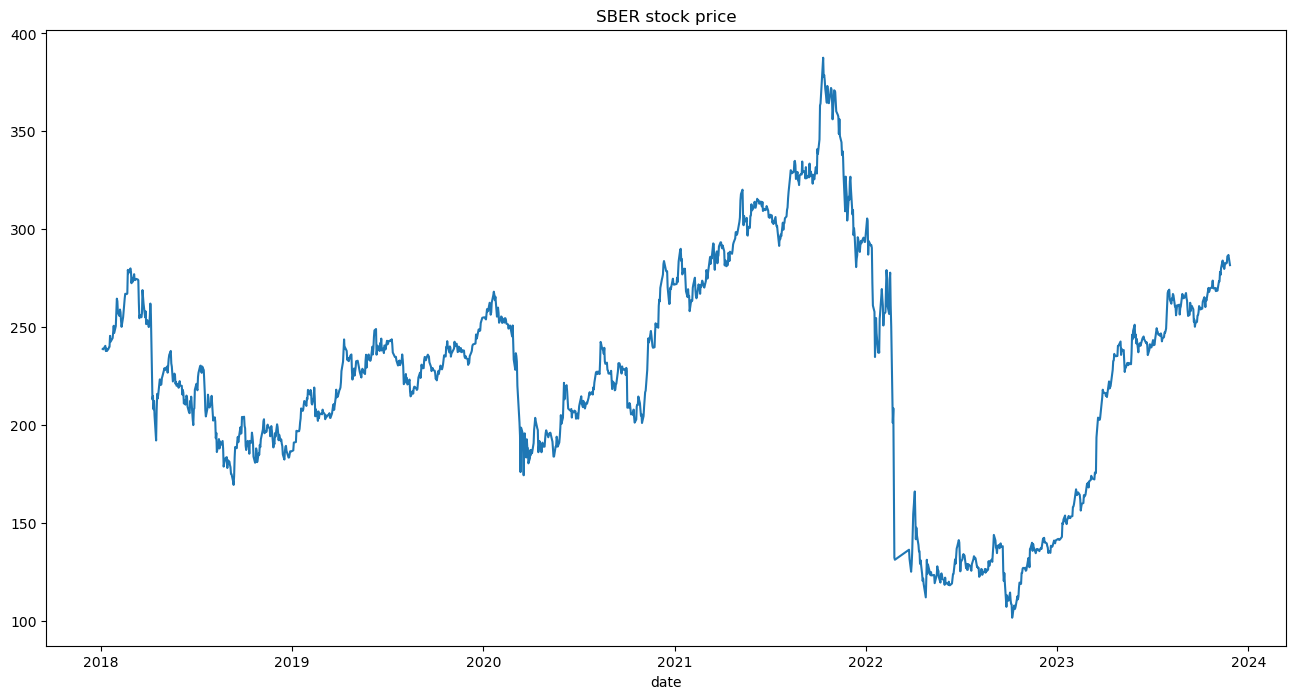

In [ ]:
plt.rcParams["figure.figsize"] = [16,8] # set size for matplotlib charts
sber['close'].plot()
plt.title ('SBER stock price')
plt.show()

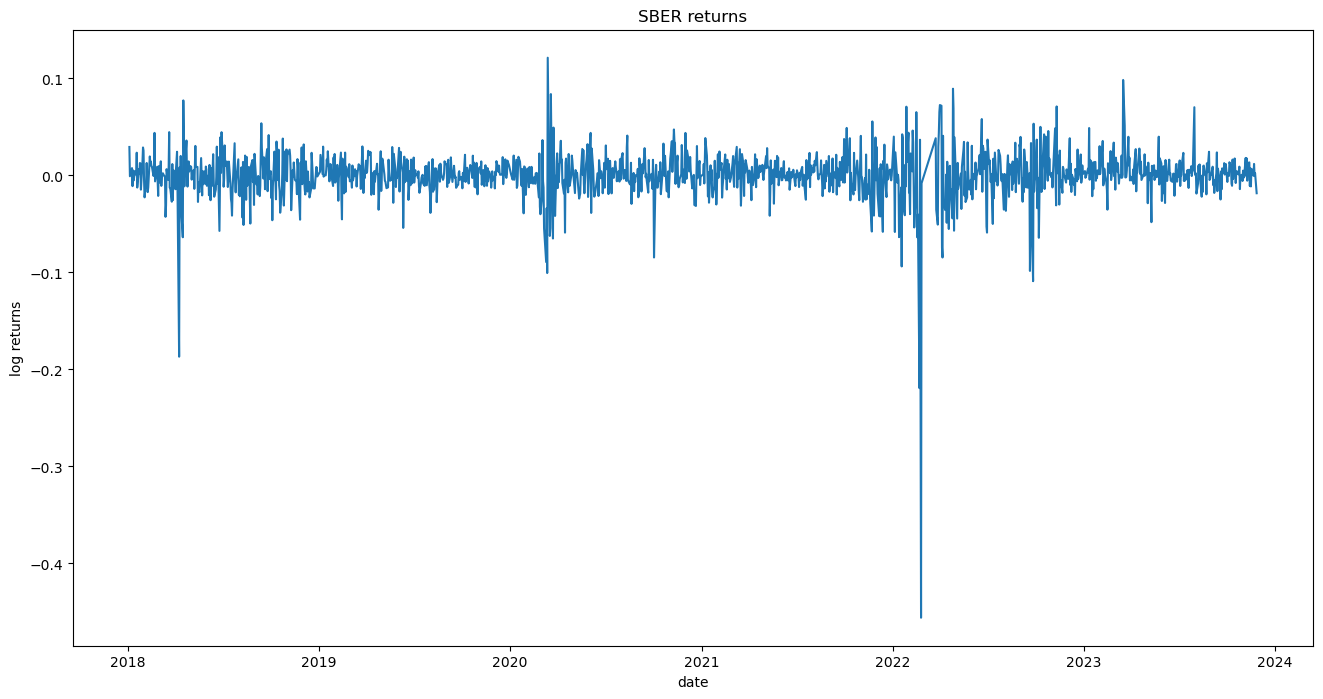

In [ ]:
sber['log_rtns'].plot()
plt.ylabel('log returns')
plt.title ('SBER returns')
plt.show()

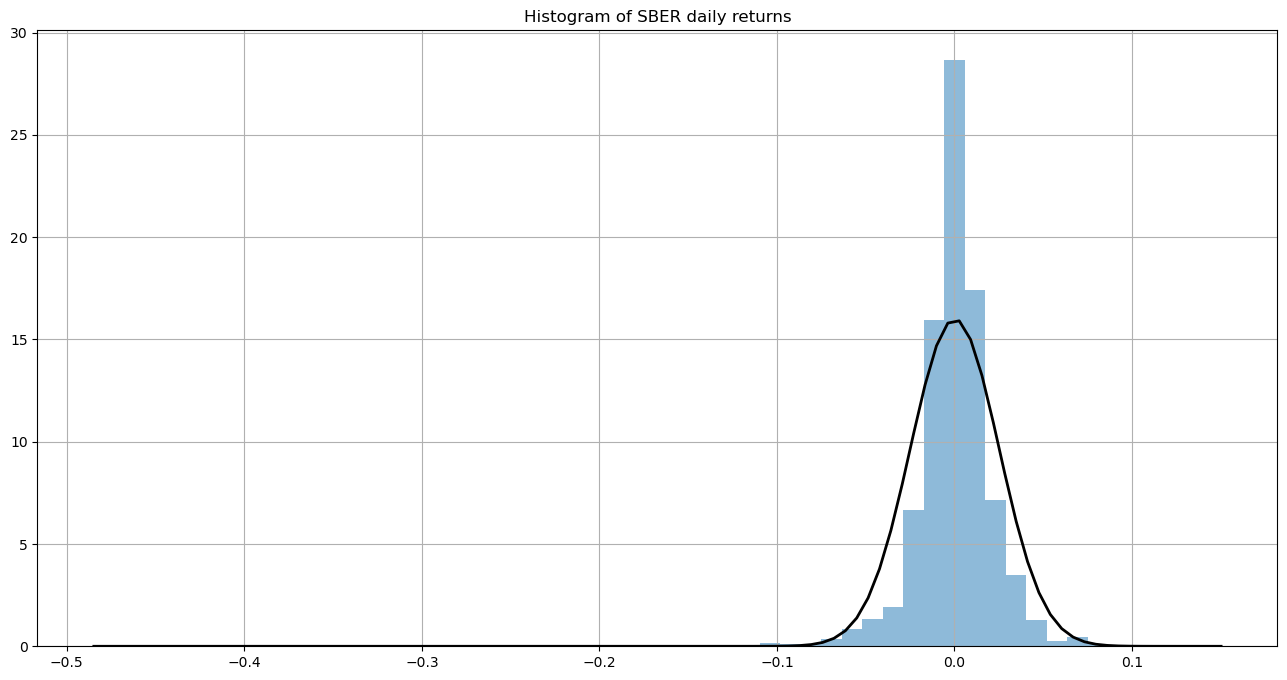

In [ ]:
sber["log_rtns"].hist(bins=50, density=True, histtype="stepfilled", alpha=0.5)
plt.title("Histogram of SBER daily returns")
mu, std = norm.fit(sber["log_rtns"])
std *np.sqrt(252) # SD of returns annualized

xmin, xmax = plt.xlim() # plot normal curve
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)

plt.plot(x, p, 'k', linewidth=2)
plt.show()

**Comment:** The distribution for SBER stock seems to be a normal distribution

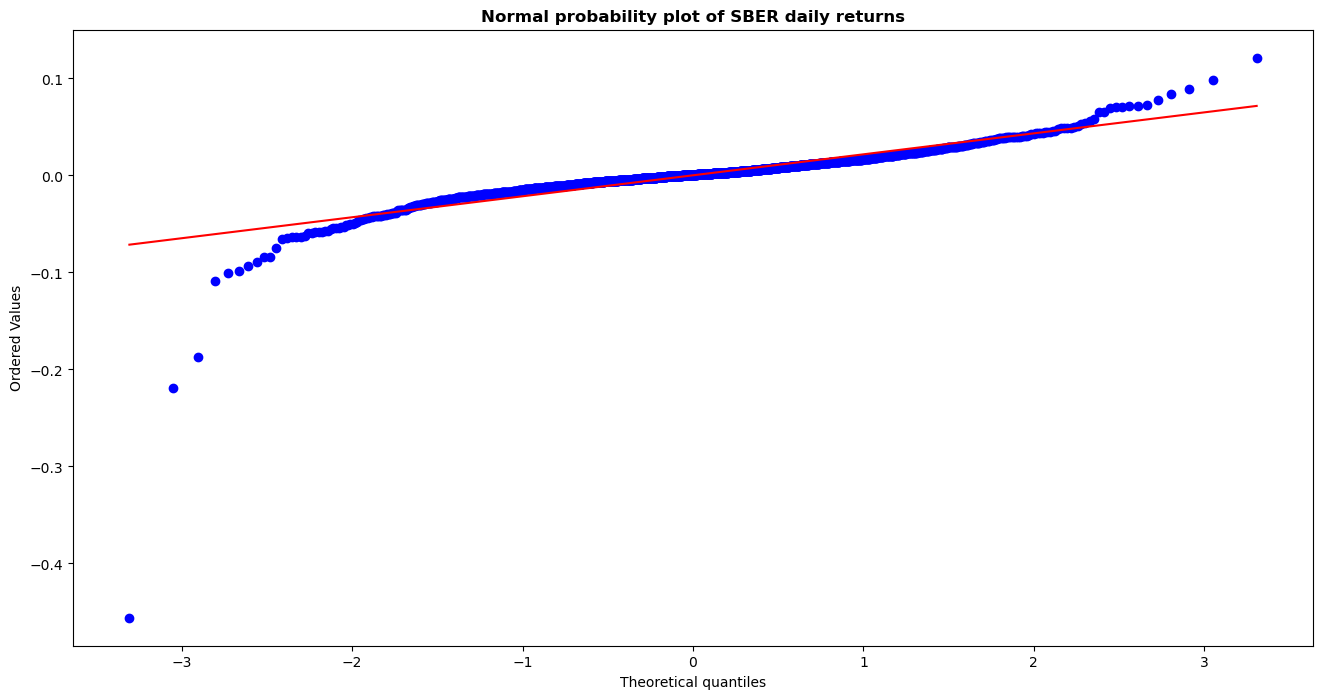

In [ ]:
scipy.stats.probplot(sber["log_rtns"],
                     dist=scipy.stats.norm,
                     plot=plt.figure().add_subplot(111))
plt.title("Normal probability plot of SBER daily returns", weight="bold");

**Comment**: The empirical graph shows that the left tail is quite heavy and the extreme values are more visible than in the histogram above

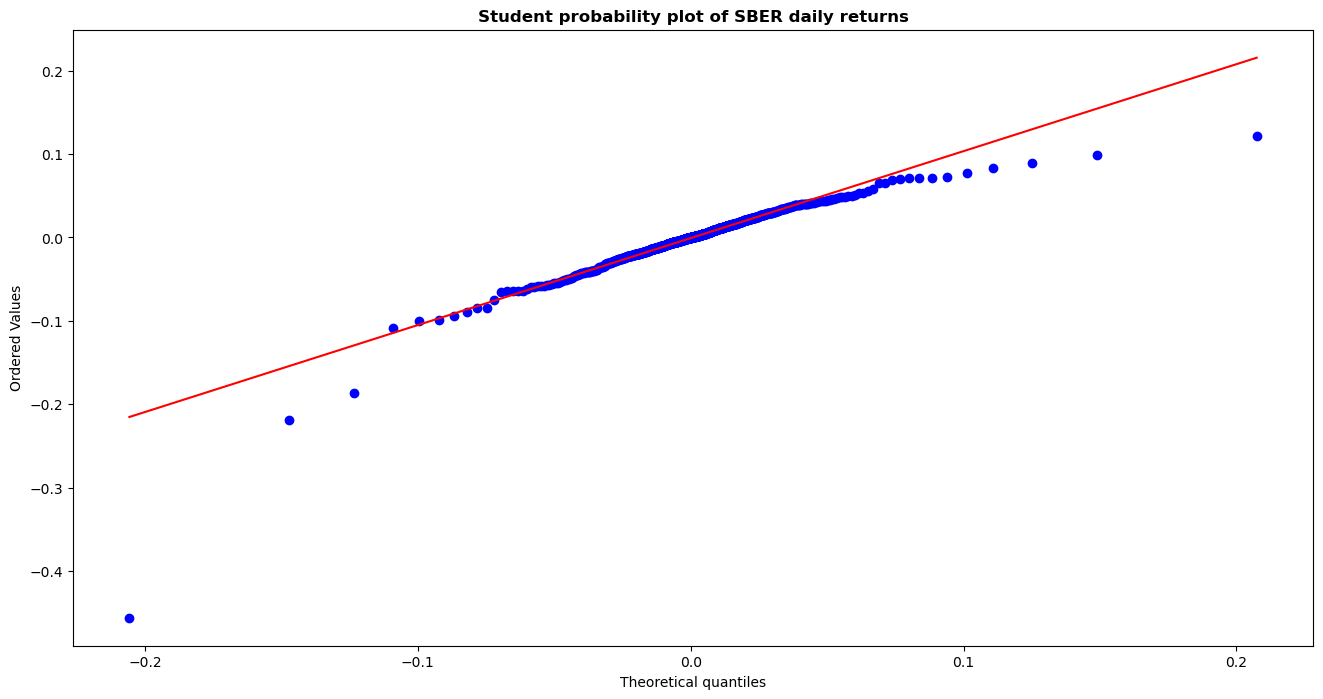

In [ ]:
tdf, tmean, tsigma = scipy.stats.t.fit(sber["log_rtns"])
scipy.stats.probplot(sber["log_rtns"],
                     dist=scipy.stats.t,
                     sparams=(tdf, tmean, tsigma),
                     plot=plt.figure().add_subplot(111))
plt.title("Student probability plot of SBER daily returns", weight="bold");

**Comment**: The blue dots are below the red line so the distribution of returns of SBER's stock is probably left-skewed. Compared with the graph for normal distribution, this graph for Student distribution has less blue dots that are far away from the red line. This is because the histogram of Student distribution has thicker tails than that of a standard normal distribution

# 01 Non-parametric estimate for VaR and ES (bootstrap method)

In [ ]:
from scipy import stats

In [ ]:
len(sber)

1472

In [ ]:
sber_1 = sber.copy()

In [ ]:
var_nonpara = []
es_nonpara = []
N = 1000
alpha = 0.05

capital = 10**6

for i in range(1, N):
    sample = np.random.choice(sber_1['log_rtns'], size = len(sber_1['log_rtns']), replace=True)
    q = np.quantile(sample, alpha)
    var_result = capital * q
    var_nonpara.append(var_result)

    ie_var = sber_1['log_rtns'] < q
    es_ = np.sum(np.multiply(sber_1['log_rtns'], ie_var)) / np.sum(ie_var) * capital
    es_nonpara.append(es_)


In [ ]:
q = sber_1['log_rtns'].quantile(alpha)
var_nonpara_ =  capital * q # non-parametric VaR
var_nonpara_

-31295.37418449639

In [ ]:
ie_var = sber_1['log_rtns'] < q
es_nonpara_ = np.sum(np.multiply(sber_1['log_rtns'], ie_var)) / np.sum(ie_var) * capital
es_nonpara_

-60724.69624967731

In [ ]:
# number of 5% bad days in total

len(sber_1) * 0.05

73.60000000000001

In [ ]:
q

-0.03129537418449639

- Using bootstrap method by generating 1000 random samples out of 1472 observations, the non-parametric estimates of **VaR and ES are 31295.37 RUB and 60724.7 RUB**.

- This means that  there is a 5% chance that the loss in the portfolio consisting of only SBER stocks will exceed 31295.37 RUB within a day, but once that threshold is crossed the expected size of loss can reach 60724.7 RUB (1.9 times higher than VaR)

- There are **74 days when the profitability was less than 3.13%**

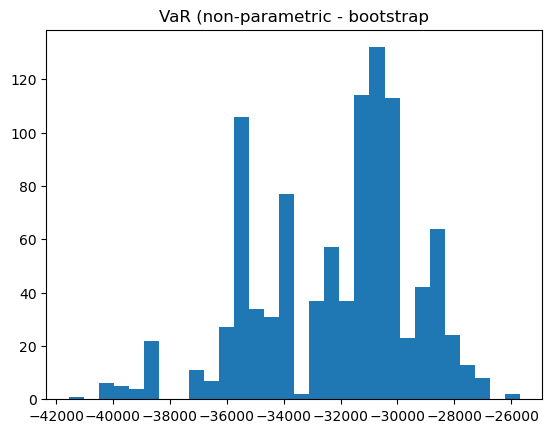

In [ ]:
plt.hist(var_nonpara, bins = 30)
plt.title('VaR (non-parametric - bootstrap')
plt.show()

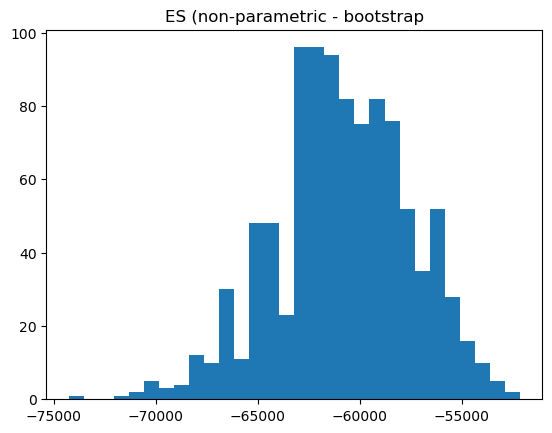

In [ ]:
plt.hist(es_nonpara, bins = 30)
plt.title('ES (non-parametric - bootstrap')
plt.show()

In [ ]:
print(round(min(var_nonpara),2))
print(round(max(var_nonpara),2))
print(round(min(es_nonpara),2))
print(round(max(es_nonpara),2))

-41549.62
-25699.94
-74257.71
-52166.4


- Confidence interval of non-parametric VaR is (-41549.62, -25699.94). The bootstrapped VaR falls within this range.
- Confidence interval of non-parametric ES is (-74257.71, 52166.4). The bootstrapped ES falls within this range.


# 02 Parametric estimate of VaR and ES (normal distribution)

In [ ]:
sber_2 = sber.copy()
mu2 = sber_2['log_rtns'].mean()
sd2 = sber_2['log_rtns'].std()

In [ ]:
q2 = norm.ppf(1-alpha)

In [ ]:
q2

1.6448536269514722

In [ ]:
var_normdist = - capital *(mu2 + sd2*q2)
var_normdist

-41181.263668140535

In [ ]:
es_normdist = -(alpha**-1 * norm.pdf(norm.ppf(alpha))*sd2 + mu2) * capital
es_normdist

-51609.480987864365

- At 95% confidence level, VaR = 41181.26 RUB. This means that there is a 5% chance that the loss in the portfolio consisting of only SBER stocks will exceed 41181.26 RUB within a day.

- At 95% confidence level, ES = 51609.48 RUB. This means that in the event of extreme market conditions (loss exceeding VaR), the expected loss will be 51609.48 RUB.


# 03 Parametric estimates of VaR and ES (Student's t distribution)

In [ ]:
from scipy.stats import t

In [ ]:
sber_3 = sber.copy()

In [ ]:
tfit = t.fit(sber_3['log_rtns'])
tfit

(2.6944504719305815, 0.0008464245488693011, 0.012858693883731193)

In [ ]:
dist_t = t.ppf(1-alpha, 5)
nu = tfit[0] # degrees of freedom
var_t = -10**6 * (mu2 + np.sqrt((nu-2)/nu) * t.ppf(1-alpha, nu) * sd2 )
var_t

-29434.325431621943

In [ ]:
xanu = t.ppf(alpha, nu)
es_t = 10**6 *  (mu2 + 1/(alpha) * (1-nu)**(-1) * (nu-2+xanu**2) * t.pdf(xanu, nu) * sd2 )
es_t

-76384.58761037671

- At 95% confidence level, **VaR = 29434.33 RUB**. This means that there is a 5% chance that the loss in the portfolio consisting of only SBER stocks will exceed 29434.33 RUB within a day.
- At 95% confidence level, **ES = 51609.48 RUB**. This means that in the event of extreme market conditions (loss exceeding VaR), the expected loss will be 76384.59 RUB.
- **Comparison: normal distribution vs t-distribution**:

        VaR (norm) > VaR (t). ES (norm) < ES (t)
        
    ES (norm) < ES (t) because t-distribution has a heavier left tail than normal distribution, and it shows that when VaR exceeds 39114.75 RUB at 95% confidence level, ES (t) projects higher loss than under normal distribution.
    
    
- **Comparison: non-parametric vs paramertric**

        VaR (non-para) = 41210.94 RUB. ES (non-para) = 72290.17 RUB
        VaR (para_norm)= 41181.26 RUB. ES (para_norm)= 51645.53 RUB
        VaR (para_t)   = 29434.33 RUB. ES (para_t)   = 76384.59 RUB

    There is a slight difference of 2097.45 rubles between parametric estimates of Var under normal distribution and t-distribution. Comparing with the non-parametric estimate of VaR, the difference is not very high.
    
    On the on other hand, expected shortfall in SBER stock have larger differences. The non-parametric ES estimate is the highest (72290.17 RUB) among 3 estimates, which means that when there is no assumption of normal distribution of returns and no assumption of the absence of outliers, the loss within one day is quite significantly higher. However because SBER stock retuns seem to be normally distributed and the sample size is not very small, parametric estimates might be more accurate. At the same time, taking into account the 2018 and 2022 - 2023 santioncs imposed by the West, it is understandable that non-parametric estimate of ES is more severe if they take into account the outliers, i.e. the extreme losses during the sanctions.
    
    
  
    
    

# 04 Estimates of VaR and ES for parametric results for normal distribution and t-distribution (bootstrap method)


## Normal distribution

In [ ]:
var_norm_bootstrap = []
es_norm_bootstrap = []
N = 1000
alpha = 0.05

capital = 10**6

for i in range(1, N):
    sample = np.random.choice(sber['log_rtns'], size = len(sber['log_rtns']), replace=True)
    q = norm.ppf(np.quantile(sample, 1-alpha))
    var_result = capital *(mu2 + sd2*q)
    var_norm_bootstrap.append(var_result)

    ie_var = sber['log_rtns'] < q
    es_result = -(alpha**-1 * norm.pdf(norm.ppf(np.quantile(sample, 1-alpha)))*sd2 + mu2) * capital
    es_norm_bootstrap.append(es_result)


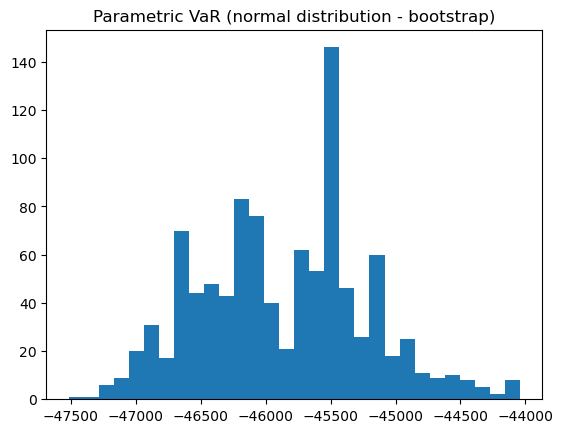

In [ ]:
plt.hist(var_norm_bootstrap, bins = 30)
plt.title('Parametric VaR (normal distribution - bootstrap)')
plt.show()

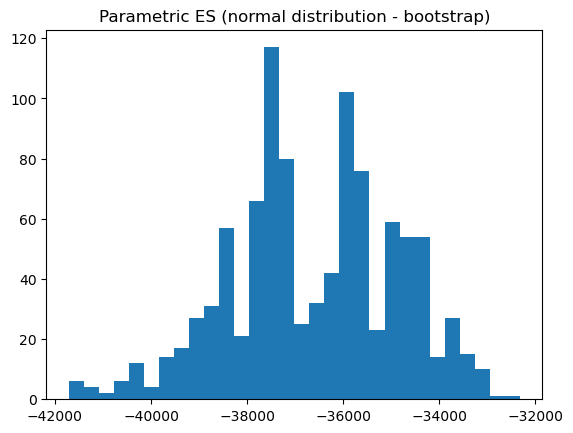

In [ ]:
plt.hist(es_norm_bootstrap, bins = 30)
plt.title('Parametric ES (normal distribution - bootstrap)')
plt.show()

In [ ]:
print(round(min(var_norm_bootstrap),2))
print(round(max(var_norm_bootstrap),2))
print(round(min(es_norm_bootstrap),2))
print(round(max(es_norm_bootstrap),2))

-47514.17
-44043.49
-41710.64
-32325.72


- Confidence interval of non-parametric VaR is (-44043.49, -44043.49). The bootstrapped VaR of 41212.2 RUB **does not fall within** this range.
- Confidence interval of non-parametric ES is (-41710.64, -32325.72). The bootstrapped ES of 51609.48 RUB **does not fall** within this range.


## t-distribution



In [ ]:
    nuu = t.fit(sample)
    nu = nuu[0]

In [ ]:
var_t_bootstrap = []
es_t_bootstrap = []
N = 1000
alpha = 0.05
capital = 10**6

for i in range(1, N):
    sample = np.random.choice(sber['log_rtns'], size = len(sber['log_rtns']), replace=True)
    q = np.quantile(sample, alpha)

    dist_t = t.ppf(1-alpha, nu)
    mu = sample.mean()
    sd = sample.std()
    var_t = - capital * (mu + np.sqrt((nu-2)/nu) * t.ppf(1-alpha, nu) * sd )
    var_t_bootstrap.append(var_t)

    xanu = t.ppf(alpha, nu)
    es_t = capital *  (mu + 1/(alpha) * (1-nu)**(-1) * (nu-2+xanu**2) * t.pdf(xanu, nu) * sd )
    es_t_bootstrap.append(es_t)

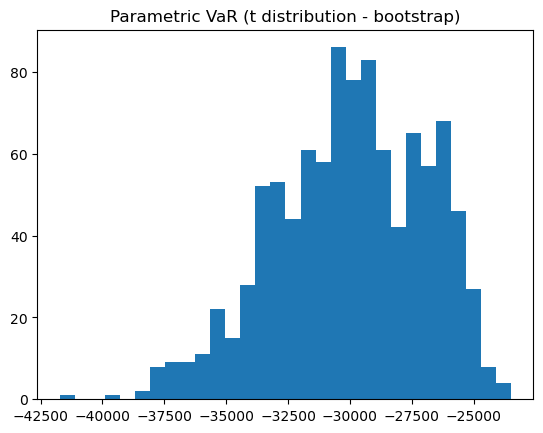

In [ ]:
plt.hist(var_t_bootstrap, bins = 30)
plt.title('Parametric VaR (t distribution - bootstrap)')
plt.show();

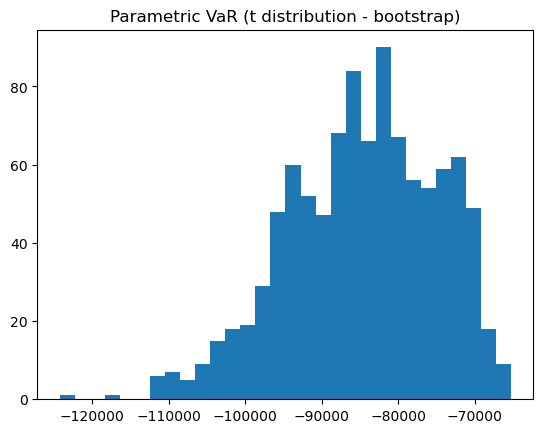

In [ ]:
plt.hist(es_t_bootstrap, bins = 30)
plt.title('Parametric VaR (t distribution - bootstrap)')
plt.show();

In [ ]:
print(round(min(var_t_bootstrap),2))
print(round(max(var_t_bootstrap),2))
print(round(min(es_t_bootstrap),2))
print(round(max(es_t_bootstrap),2))

-41715.78
-23493.87
-124236.16
-65276.28


With t-distribution the histograms of VaR and ES (bootstrapped) look **more skewed** than with normal distribution, which also aligns with the assumption at the beginning. Confidence intervals with t-distribution are also wider.
- Confidence interval of non-parametric VaR is (-41715.78, -23493.87). The bootstrapped VaR of 41212.2 RUB falls within this range.
- Confidence interval of non-parametric ES is (-124236.16, -65276.28). The bootstrapped ES of 51609.48 RUB falls within this range.


# Portfolio 1

In [ ]:
tickers = ['SBER', 'VTBR', "MTSS", "MAGN", "OZON"]

SBER = get_moex_stock('SBER', start = '2012-01-01', end = today)
VTBR = get_moex_stock('VTBR', start = '2012-01-01', end = today)
MTSS = get_moex_stock('MTSS', start = '2012-01-01', end = today)
MAGN = get_moex_stock('MAGN', start = '2012-01-01', end = today)
OZON = get_moex_stock("OZON", start = '2012-01-01', end = today)

In [ ]:
rtns = pd.concat([SBER['log_rtns'], VTBR['log_rtns'], MTSS['log_rtns'], MAGN['log_rtns'], OZON['log_rtns']],
                    axis = 'columns')
rtns.columns = tickers
rtns = rtns.dropna()
rtns

,SBER,VTBR,MTSS,MAGN,OZON
date,,,,,
2020-11-25,1.8348%,-0.3118%,1.3251%,0.9452%,-2.6392%
2020-11-26,-0.7211%,0.4877%,-0.0784%,0.3639%,-0.3391%
2020-11-27,0.5940%,2.0465%,0.6877%,0.4092%,2.7142%
2020-11-30,-0.7821%,-1.4805%,0.2023%,1.4595%,1.5092%
2020-12-01,4.3812%,1.3083%,0.3724%,0.2756%,-0.3752%
...,...,...,...,...,...
2023-11-20,0.4641%,0.1230%,0.3340%,-0.2427%,3.4591%
2023-11-21,-0.0424%,0.2659%,1.0685%,0.1457%,4.7070%
2023-11-22,1.1847%,2.8988%,-1.0871%,1.7606%,-0.5197%


In [ ]:
prices = pd.concat([SBER, VTBR, MTSS, MAGN, OZON], axis="columns")
prices = prices["close"]
prices.columns = ["SBER", "VTBR", 'MTSS', "MAGN", "OZON"]

The covariance matrix shows that baeed on historical data, tock returns from each pair out of 5 companiess will move together

In [ ]:
cov_mat = rtns.cov()
cov_mat

,SBER,VTBR,MTSS,MAGN,OZON
SBER,0.0817%,0.0739%,0.0347%,0.0366%,0.0594%
VTBR,0.0739%,0.0979%,0.0356%,0.0387%,0.0678%
MTSS,0.0347%,0.0356%,0.0474%,0.0215%,0.0373%
MAGN,0.0366%,0.0387%,0.0215%,0.0536%,0.0401%
OZON,0.0594%,0.0678%,0.0373%,0.0401%,0.1371%


Returns of SBER and VTBR are strongly correlated

In [ ]:
corr_mat = rtns.corr()
corr_mat

,SBER,VTBR,MTSS,MAGN,OZON
SBER,100.0000%,82.6474%,55.7820%,55.2351%,56.1078%
VTBR,82.6474%,100.0000%,52.2315%,53.4319%,58.4816%
MTSS,55.7820%,52.2315%,100.0000%,42.7096%,46.2780%
MAGN,55.2351%,53.4319%,42.7096%,100.0000%,46.7316%
OZON,56.1078%,58.4816%,46.2780%,46.7316%,100.0000%


In [ ]:
import riskfolio as rp
#portfolio object
port = rp.Portfolio(returns = rtns)

In [ ]:
pd.options.display.float_format = '{:.4%}'.format

rm = 'MV'

method_mu='hist'
method_cov='hist'
port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

w = port.optimization(model='Classic', rm=rm, obj='Sharpe', rf=0.00, l=0, hist=True)

In [ ]:
w

,weights
SBER,0.0000%
VTBR,0.0000%
MTSS,0.0000%
MAGN,100.0000%
OZON,0.0000%


# Portfolio 2

In [ ]:

tickers = ['SBER', 'GAZP', "MTSS", "MAGN", "ROSN"]

SBER = get_moex_stock('SBER', start = '2012-01-01', end = today)
GAZP = get_moex_stock('GAZP', start = '2012-01-01', end = today)
MTSS = get_moex_stock('MTSS', start = '2012-01-01', end = today)
MAGN = get_moex_stock('MAGN', start = '2012-01-01', end = today)
ROSN = get_moex_stock("ROSN", start = '2012-01-01', end = today)

rtns = pd.concat([SBER['log_rtns'], GAZP['log_rtns'], MTSS['log_rtns'], MAGN['log_rtns'], ROSN['log_rtns']],
                    axis = 'columns')
rtns.columns = tickers
rtns = rtns.dropna()
rtns

,SBER,GAZP,MTSS,MAGN,ROSN
date,,,,,
2012-01-04,0.013379,-0.003329,0.005630,-0.007675,0.019982
2012-01-05,-0.011682,0.001638,0.011854,-0.010247,-0.016228
2012-01-06,0.007843,-0.005659,0.047773,0.008455,0.010773
2012-01-09,0.008140,0.006054,0.005526,0.002258,0.004646
2012-01-10,0.034335,0.013114,0.019351,0.036207,0.021767
...,...,...,...,...,...
2023-11-21,-0.000424,-0.002177,0.010685,0.001457,0.003262
2023-11-22,0.011847,0.001331,-0.010871,0.017606,-0.002832
2023-11-23,0.000105,-0.007648,-0.013616,-0.004205,-0.001634


In [ ]:
prices = pd.concat([SBER, GAZP, MTSS, MAGN, ROSN], axis="columns")
prices = prices["close"]
prices.columns = ["SBER", "GAZP", 'MTSS', "MAGN", "ROSN"]

In [ ]:
cov_mat = rtns.cov()
cov_mat

,SBER,GAZP,MTSS,MAGN,ROSN
SBER,0.000500,0.000269,0.000203,0.000210,0.000273
GAZP,0.000269,0.000420,0.000163,0.000166,0.000243
MTSS,0.000203,0.000163,0.000347,0.000134,0.000164
MAGN,0.000210,0.000166,0.000134,0.000442,0.000168
ROSN,0.000273,0.000243,0.000164,0.000168,0.000399


In [ ]:
corr_mat = rtns.corr()
corr_mat

,SBER,GAZP,MTSS,MAGN,ROSN
SBER,1.000000,0.587967,0.486905,0.447041,0.612148
GAZP,0.587967,1.000000,0.428174,0.385134,0.593601
MTSS,0.486905,0.428174,1.000000,0.341527,0.442101
MAGN,0.447041,0.385134,0.341527,1.000000,0.400429
ROSN,0.612148,0.593601,0.442101,0.400429,1.000000


In [ ]:
import riskfolio as rp

port = rp.Portfolio(returns = rtns)

In [ ]:
pd.options.display.float_format = '{:.4%}'.format

method_mu='hist'
method_cov='hist'
port.assets_stats(method_mu = method_mu, method_cov = method_cov, d=0.94)

w = port.optimization(model='Classic', rm= 'MV', obj='Sharpe', rf=0.00, l=0, hist=True)

In [ ]:
w

,weights
SBER,28.7846%
GAZP,0.0000%
MTSS,0.0000%
MAGN,54.0766%
ROSN,17.1387%


**Comment:** My original choice is a portfolio consisting of SBER, MTSS, MAGN, ROSN and VTBR. However the result of optimal weight for this porfolio was 100% - MAGN stocks and 0% for the others. So it was perhaps a really bad combination considering I - as a foreigner - don't know much about Russian companies accept for very popular ones
This portfolio looks more okay.


*Unfortunately from this part the remaining codes for estimating the effiency of the portfolio all take about 10000 years to finish so I would stop here.*

https://forms.gle/KThkNBMFBj5JpCFt5